In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data = os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install transformers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [3]:
BATCH_SIZE = 16
MAX_LEN = 512
EPOCHS = 10

TOKENIZER = BertTokenizer.from_pretrained('bert-base-cased')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

cuda:0


# Data Cleaning/ Preprocessing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


<AxesSubplot:xlabel='sentiment', ylabel='count'>

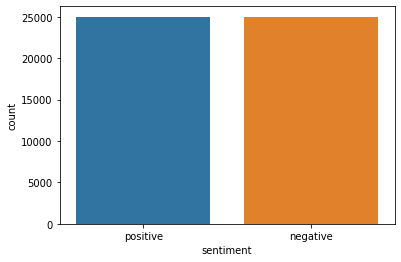

In [4]:
df = pd.read_csv(data)
print(df.info())

sns.countplot(x=df.sentiment)

In [5]:
def remove_html_tags(string):
    result = re.sub('<.*?>','',string)
    return result

df.sentiment = df.sentiment.apply(lambda x: 1 if x == "positive" else 0)
df.review = df.review.apply(lambda x : remove_html_tags(x))

train, test = train_test_split(df, test_size=0.2)
train, test = train.reset_index(drop=True), test.reset_index(drop=True) 

print(train)

                                                  review  sentiment
0      We all enjoyed the movie. It is a very charmin...          1
1      Brilliant thriller, deserving far more fame, M...          1
2      And a self-admitted one to boot. At one point ...          0
3      I mean really, how could Charles Band the head...          0
4      Did you ever see the film "Marathon Man"? The ...          0
...                                                  ...        ...
39995  For a kid's movie, this is great. As an adult ...          1
39996  Otherwise it is one of the worst movies I've e...          0
39997  It ends with the declaration that "the film yo...          1
39998  Last fall (of 2001), I took a film class that ...          0
39999  You can't really call Roy Andersson prolific, ...          1

[40000 rows x 2 columns]


# Preparing dataset for Transformer

In [6]:
class BERTDataset:
    def __init__(self, review, sentiment):
        self.review = review
        self.sentiment = sentiment
        self.tokenizer = TOKENIZER
        self.max_len = MAX_LEN

    def __len__(self):
        return len(self.review)

    def __getitem__(self, item):
        review = str(self.review[item])

        encoding = self.tokenizer.encode_plus(review, None, add_special_tokens=True, 
            max_length=self.max_len, padding='max_length', truncation= True)
        
        return {   
            "ids": torch.tensor(encoding["input_ids"], dtype=torch.long),
            "mask": torch.tensor(encoding["attention_mask"], dtype=torch.long),
            "token_type_ids": torch.tensor(encoding["token_type_ids"], dtype=torch.long),
            "sentiments": torch.tensor(self.sentiment[item], dtype=torch.float),
        }

def create_data_loader(df):
    ds = BERTDataset(review=df.review.values, sentiment=df.sentiment.values)
    return DataLoader(ds, batch_size=BATCH_SIZE, num_workers=2)

train_data_loader = create_data_loader(train)
test_data_loader = create_data_loader(test)

data = next(iter(train_data_loader))
print(data.keys())
print(data["ids"].shape)

dict_keys(['ids', 'mask', 'token_type_ids', 'sentiments'])
torch.Size([16, 512])


# Model

In [7]:
class BERTSentiment(nn.Module):
    def __init__(self):
        super(BERTSentiment, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased', return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size,1) 
        
    def forward(self, ids, mask, token_type_ids):
        _, pooled_output = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids) 
        return self.out(self.drop(pooled_output))

In [8]:
model = BERTSentiment()
model = model.to(device)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

# Traning/ Testing

In [9]:
def train_model(data_loader, model, optimizer, scheduler, loss_fn):
    model.train()
    avg_losses = []
    print_freq = 100
    
    for epoch in range(EPOCHS):
        running_loss = 0.0
        for i,d in enumerate(data_loader):
            ids = d["ids"].to(device, dtype=torch.long)
            token_type_ids = d["token_type_ids"].to(device, dtype=torch.long)
            mask = d["mask"].to(device, dtype=torch.long)
            sentiments = d["sentiments"].to(device, dtype=torch.float)

            optimizer.zero_grad()

            output = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            loss = loss_fn(output, sentiments.view(-1,1))

            loss.backward()

            optimizer.step()
            scheduler.step()
            
            # Print statistics.
            running_loss += loss.item()
            if i % print_freq == print_freq - 1: # Print every several mini-batches.
                avg_loss = running_loss / print_freq
                print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(epoch+1, i+1, avg_loss))
                avg_losses.append(avg_loss)
                running_loss = 0.0
    print('Finished Training.')
    return avg_losses

In [14]:
def eval_model(data_loader, model):
    model.train()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for d  in data_loader:
            ids = d["ids"].to(device, dtype=torch.long)
            token_type_ids = d["token_type_ids"].to(device, dtype=torch.long)
            mask = d["mask"].to(device, dtype=torch.long)
            sentiments = d["sentiments"].to(device, dtype=torch.float)

            output = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            
            predicted = (torch.sigmoid(output)).cpu().numpy() >=0.5
            predicted = np.concatenate(predicted).ravel()  #flaten a list of numpy array 1x16 to 16
            sentiments = sentiments.cpu().numpy()
            
            total += len(sentiments)
            correct += (predicted == sentiments).sum().item()
            
    print('Accuracy of the network on the test data: %d %%' % (100 * correct / total))

In [11]:
total_step = len(train_data_loader)*EPOCHS
optimizer = AdamW(model.parameters(), lr = 2e-5, correct_bias= False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_step)
loss_fn = nn.BCEWithLogitsLoss().to(device)

[epoch: 1, i:   100] avg mini-batch loss: 0.462
[epoch: 1, i:   200] avg mini-batch loss: 0.330
[epoch: 1, i:   300] avg mini-batch loss: 0.302
[epoch: 1, i:   400] avg mini-batch loss: 0.280
[epoch: 1, i:   500] avg mini-batch loss: 0.275
[epoch: 1, i:   600] avg mini-batch loss: 0.230
[epoch: 1, i:   700] avg mini-batch loss: 0.235
[epoch: 1, i:   800] avg mini-batch loss: 0.216
[epoch: 1, i:   900] avg mini-batch loss: 0.233
[epoch: 1, i:  1000] avg mini-batch loss: 0.217
[epoch: 1, i:  1100] avg mini-batch loss: 0.227
[epoch: 1, i:  1200] avg mini-batch loss: 0.217
[epoch: 1, i:  1300] avg mini-batch loss: 0.217
[epoch: 1, i:  1400] avg mini-batch loss: 0.221
[epoch: 1, i:  1500] avg mini-batch loss: 0.203
[epoch: 1, i:  1600] avg mini-batch loss: 0.215
[epoch: 1, i:  1700] avg mini-batch loss: 0.209
[epoch: 1, i:  1800] avg mini-batch loss: 0.183
[epoch: 1, i:  1900] avg mini-batch loss: 0.210
[epoch: 1, i:  2000] avg mini-batch loss: 0.205
[epoch: 1, i:  2100] avg mini-batch loss

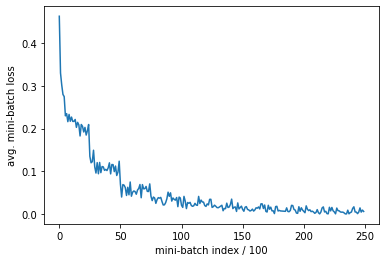

In [12]:
train_loss = train_model(train_data_loader, model, optimizer, scheduler,loss_fn)

plt.plot(train_loss)
plt.xlabel('mini-batch index / {}'.format(100))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [15]:
eval_model(test_data_loader, model)

Accuracy of the network on the test data: 93 %
